In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
import numpy as np
import pandas as pd
import os
import sys
# 导入上一个文件目录input下的文件
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../input")))
from dataloader import ImagenetMini
from dnnsutils import get_path_from_path
from preproducednns import VGG16, VGG19, VGG16_noBN, VGG19_noBN

In [2]:
# 环境变量
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


In [3]:
# 拿到环境变量
KAGGLE_MODE = os.environ.get('KAGGLE_MODE', 'CLOUD')

print(f'KAGGLE_MODE = {KAGGLE_MODE}')

KAGGLE_MODE = DEV


In [4]:
paths=[]
labels=[]

# 获取路径
parent_path = get_path_from_path(os.getcwd(), 1)

for dirname, _, filenames in os.walk(f'{parent_path}/input/imagenetmini-1000/imagenet-mini/train'):
    for filename in filenames:
        if filename.endswith('.JPEG'):
            paths.append(os.path.join(dirname, filename))
            labels.append(dirname.split('/')[-1])

vpath=[]
vlabels=[]
for dirname, _, filenames in os.walk(f'{parent_path}/input/imagenetmini-1000/imagenet-mini/val'):
    for filename in filenames:
        if filename.endswith('.JPEG'):
            vpath.append(os.path.join(dirname, filename))
            vlabels.append(dirname.split('/')[-1])


class_names = sorted(set(labels))
print(f'Total number of classes: {len(class_names)}')

N = list(range(len(class_names)))

'''
- normal_mapping就是从类别名称到整数标签的映射
- inverse_mapping就是从整数标签到类别名称的映射
有了这两个映射，可以方便地在模型训练、推理和评估时进行类别标签的转换和解码。
'''
normal_mapping = dict(zip(class_names, N))
inverse_mapping = dict(zip(N, class_names))

# 数据太多，只取前100个，仅DEV模式下使用
if KAGGLE_MODE == 'DEV':
    paths = paths[:100]
    labels = labels[:100]

    vpath = vpath[:100]
    vlabels = vlabels[:100]


df = pd.DataFrame({'path': paths, 'label': labels})
df['label'] = df['label'].map(normal_mapping)

vdf = pd.DataFrame({'path': vpath, 'label': vlabels})
vdf['label'] = vdf['label'].map(normal_mapping)

print(f'Total number of training images: {len(df)}')
print(f'Total number of validation images: {len(vdf)}')

Total number of classes: 1000
Total number of training images: 100
Total number of validation images: 100


torch.Size([20, 3, 224, 224]) tensor([895, 263, 146, 895, 895, 895, 263, 146, 895, 895, 146, 895, 895, 895,
        895, 263, 895, 146, 263, 146])


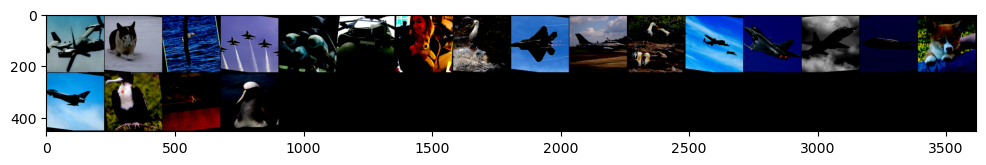

In [5]:

# 数据处理transform
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
train_dataset = ImagenetMini(df, transform=transform)
val_dataset = ImagenetMini(vdf, transform=transform)

# 数据加载
'''
- 在训练阶段，通常使用shuffle=True来随机化数据顺序
- 而在验证阶段最好将shuffle=False，以确保一致和可靠的评估过程。
'''
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20)

# check image and labels
for images, labels in train_loader:
    print(images.shape, labels)
    break

im = make_grid(images, nrow=16)

plt.figure(figsize=(12, 12))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

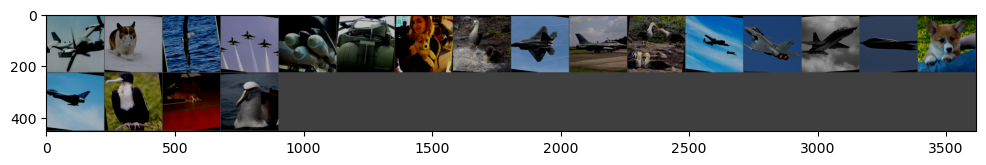

In [6]:
inv_normalize = transforms.Normalize(
    mean=[-.5], std=[1/.5]
)

im_inv = inv_normalize(im)

plt.figure(figsize=(12, 12))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

In [7]:
torch.manual_seed(42)

model = VGG16_noBN(3, 1000).to(device)


## 简单训练一下

100%|██████████| 3/3 [03:39<00:00, 73.06s/it]


Total Time: 3.6532735308011373 minutes


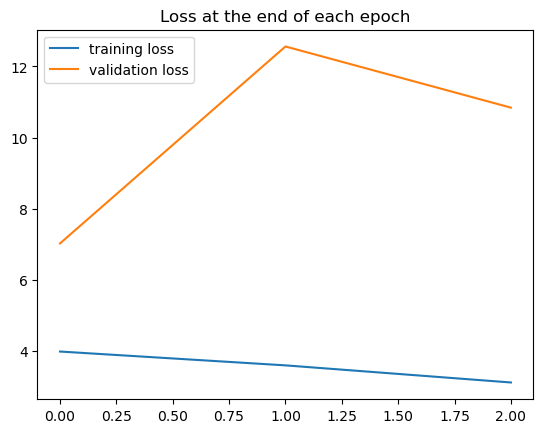

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10 if KAGGLE_MODE == 'CLOUD' else 3

import time
start_time = time.time()
train_losses = []
val_losses = []
train_correct = []
val_correct = []

for i in trange(epochs):
    trn_corr = 0
    val_corr = 0
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        # print(f'batch: {b}  X_train.shape: {X_train.shape}  y_train.shape: {y_train.shape}')
        y_pred = model(X_train.to(device))
        loss = criterion(y_pred, y_train.to(device))
 
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{32*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(32*b):7.3f}%')
    train_losses.append(loss.item())
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(val_loader):
            y_val_pred = model(X_val.to(device))
            predicted = torch.max(y_val_pred.data, 1)[1]
            batch_corr = (predicted == y_val.to(device)).sum()
            val_corr += batch_corr
    loss = criterion(y_val_pred, y_val.to(device))
    val_losses.append(loss.item())
    val_correct.append(val_corr)

total_time = time.time() - start_time
print(f'Total Time: {total_time/60} minutes')

# 保存模型
torch.save(model.state_dict(), 'VGG16_noBN_10epochs.pt')

plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()